In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Define the path to your data folders
#orchard_path = "mountdata/euroorchardsSR"
#forest_path = "mountdata/euroforestsSR"

orchard_path = 'mountdata/zaforchards2-ts'
forest_path = 'mountdata/zafforests2-ts'

# Define hyperparameters
batch_size = 8
learning_rate = 0.001
num_epochs = 40

# Check if CUDA/GPU is available (optional but recommended for faster training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import torchvision.models as models

dropout_prob = .2

class ResModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ResModel, self).__init__()
        
        # Load the pre-trained MobileNetV2 model
        resnet18 = models.resnet18(pretrained=True)
        
       # Remove the classification head of ResNet18
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Add custom layers for your task
#        self.fc = nn.Sequential(
#            nn.Flatten(),
#            nn.Linear(512, num_classes)
#        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),  # You can adjust the output size of the linear layer
            nn.ReLU(),           # Add activation function
            nn.Dropout(p=dropout_prob),  # Dropout layer
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        # Feature extraction with ResNet18
        x = self.features(x)

        # Fully connected layers
        x = self.fc(x)

        return x

model = ResModel().to(device)
        


/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
#import tifffile
from PIL import Image
import rasterio as rio

#import cv2
#import gdal
from torch.utils.data.sampler import SubsetRandomSampler
#import imagecodecs
from skimage import io

shape = (160,160,3)

from torch.utils.data.sampler import SubsetRandomSampler

anomalies = []

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, num_channel=3):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = os.listdir(data_dir)
        self.num_channel = num_channel


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        '''
        if idx % 2 == 1 or idx + 1 >= len(self.file_list):  # Handle single/last image gracefully
            img_name = os.path.join(self.data_dir, self.file_list[idx])
     #       if img_name in anoms:
      #          return torch.zeros(50, 50, 3)
            image = np.squeeze(np.load(img_name, allow_pickle=True))
            label = 0 if "orchard" in self.data_dir else 1
            return image, label, img_name  # Return single image and label

        # Process a pair of images
        img_name1 = os.path.join(self.data_dir, self.file_list[idx])
        img_name2 = os.path.join(self.data_dir, self.file_list[idx + 1])  # Get the next image
    
    #    if img_name1 in anoms or img_name2 in anoms:
            # Handle cases where one or both images are anomalies
    #        return torch.zeros(50, 50, 3), torch.zeros(50, 50, 3), img_name1, img_name2
    
        image1 = np.squeeze(np.load(img_name1, allow_pickle=True))
        image2 = np.squeeze(np.load(img_name2, allow_pickle=True))
    
        # Concatenate images along the channel dimension
        concatenated_image = np.concatenate((image1, image2), axis=2)
    
        label = 0 if "orchard" in self.data_dir else 1
        return concatenated_image, label, img_name1, img_name2
        '''
        img_name = os.path.join(self.data_dir, self.file_list[idx],'2023-01-01.tif')
        img_name2 = os.path.join(self.data_dir, self.file_list[idx],'2023-06-01.tif')

        with rio.open(img_name) as img :
                image= img.read()
                image = image.astype('float32')
    
                image = image[:self.num_channel,2:52,2:52]
                image = np.transpose(image,(1,2,0))
                #print
                if image.shape != (50,50,self.num_channel):
                    print('anomaly')
                    anomalies.append(img_name)
                    return torch.zeros(100, 50,self.num_channel), -1
                
                if self.transform:
                    image = self.transform(image)
                with rio.open(img_name2) as img2 :
                    image2= img2.read()
                    image2 = image2.astype('float32')
        
                    image2 = image2[:self.num_channel,2:52,2:52]
                    image2 = np.transpose(image2,(1,2,0))
                    #print
                    if image2.shape != (50,50,self.num_channel):
                        print('anomaly')
                        anomalies.append(img_name2)
                        return torch.zeros(100, 50,self.num_channel), -1
                    
                    if self.transform:
                        image2 = self.transform(image2)
                    
        #image = np.squeeze(np.load(img_name, allow_pickle=True))
        #image2 = np.squeeze(np.load(img_name2, allow_pickle=True))
                    image = np.concatenate((image,image2), axis=2)

        label = 0 if "orchard" in self.data_dir else 1  # Assuming "orchard" is class 0 and "forest" is class 1
        return image, label, img_name
        

# Data augmentation and normalization
transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create data loaders for training and validation
#orchard_dataset = CustomDataset(orchard_path, transform)
#forest_dataset = CustomDataset(forest_path, transform)
dataset = CustomDataset(orchard_path, transform, 3) + CustomDataset(forest_path, transform, 3)
split_ratio = 0.8
num_data = len(dataset)
split = int(np.floor(split_ratio * num_data))
indices = list(range(num_data))

indices = [idx for idx in indices if dataset[idx][1] != -1]

np.random.shuffle(indices)


# Create data samplers for training and testing sets
train_indices, test_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create data loaders for training and testing
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
# Use DataLoader to handle batching and shuffling
#orchard_loader = DataLoader(orchard_dataset, batch_size=batch_size, shuffle=True)
#forest_loader = DataLoader(forest_dataset, batch_size=batch_size, shuffle=True)

/home/angelats11/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly


In [3]:
print(anomalies)

['mountdata/zaforchards2-ts/Image_Lat_-23.75421204450379_Lon_30.040246170137554/2023-01-01.tif', 'mountdata/zaforchards2-ts/Image_Lat_-24.369803520775992_Lon_30.706244153045976/2023-06-01.tif', 'mountdata/zaforchards2-ts/Image_Lat_-24.48498068537993_Lon_30.852352002910354/2023-01-01.tif', 'mountdata/zaforchards2-ts/Image_Lat_-25.42440065060146_Lon_31.10614799508328/2023-01-01.tif', 'mountdata/zaforchards2-ts/Image_Lat_-30.702534775095742_Lon_30.300410573592487/2023-06-01.tif', 'mountdata/zaforchards2-ts/Image_Lat_-33.424104508473484_Lon_19.219134895787988/2023-06-01.tif', 'mountdata/zaforchards2-ts/Image_Lat_-33.514870067967394_Lon_19.252485261420663/2023-01-01.tif', 'mountdata/zafforests2-ts/Image_Lat_-22.750359611743477_Lon_30.076954472051707/2023-06-01.tif', 'mountdata/zafforests2-ts/Image_Lat_-23.49966398398501_Lon_31.317466535560662/2023-06-01.tif', 'mountdata/zafforests2-ts/Image_Lat_-24.1122505768815_Lon_31.12769900959532/2023-01-01.tif', 'mountdata/zafforests2-ts/Image_Lat_-24.

In [4]:
import torch.nn.functional as F
num_epochs = 30

def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch, (images, labels, img_name) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    return total_loss / (batch + 1), train_accuracy

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    misclassified_paths = []
    with torch.no_grad():
        for batch, (images, labels, img_name) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            incorrect_indices = (predicted != labels).nonzero()
            misclassified_paths.extend([img_name[i] for i in incorrect_indices])


    val_accuracy = 100 * correct / total
    return total_loss / (batch + 1), val_accuracy, misclassified_paths


In [7]:
import rasterio as rio
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop with validation
trnl = []
vall = []
trna=[]
vala=[]
epochs = [x for x in range(num_epochs)]
mistakes_s2 = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy, misclf = validate(model, test_loader, criterion)
    trnl.append(train_loss)
    vall.append(val_loss)
    trna.append(train_accuracy)
    vala.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    if epoch == 20:
        print('epoch 20 erros')
    if epoch == num_epochs-1:
        print('last epoch errors')
        print(misclf)
        mistakes_s2 = misclf
        
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trnl,label='train loss')
plt.plot(epochs,vall,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Epoch [1/30] - Train Loss: 0.4962, Train Acc: 78.21%, Val Loss: 0.5621, Val Acc: 78.22%
Epoch [2/30] - Train Loss: 0.4222, Train Acc: 81.35%, Val Loss: 0.3570, Val Acc: 86.22%
Epoch [3/30] - Train Loss: 0.3694, Train Acc: 83.91%, Val Loss: 0.3638, Val Acc: 87.11%
Epoch [4/30] - Train Loss: 0.4279, Train Acc: 81.55%, Val Loss: 0.3502, Val Acc: 84.44%
Epoch [5/30] - Train Loss: 0.3353, Train Acc: 86.36%, Val Loss: 0.3272, Val Acc: 86.67%
Epoch [6/30] - Train Loss: 0.3578, Train Acc: 86.36%, Val Loss: 0.3743, Val Acc: 88.00%
Epoch [7/30] - Train Loss: 0.3289, Train Acc: 85.38%, Val Loss: 0.3792, Val Acc: 86.22%
Epoch [8/30] - Train Loss: 0.3157, Train Acc: 86.36%, Val Loss: 0.3784, Val Acc: 85.33%
Epoch [9/30] - Train Loss: 0.2829, Train Acc: 88.32%, Val Loss: 0.4752, Val Acc: 83.56%
Epoch [10/30] - Train Loss: 0.2788, Train Acc: 89.01%, Val Loss: 0.6168, Val Acc: 75.11%
Epoch [11/30] - Train Loss: 0.3151, Train Acc: 87.14%, Val Loss: 0.7411, Val Acc: 84.44%
Epoch [12/30] - Train Loss: 0.

SystemError: <class 'rasterio._err.CPLE_OpenFailedError'> returned a result with an error set

Training complete.


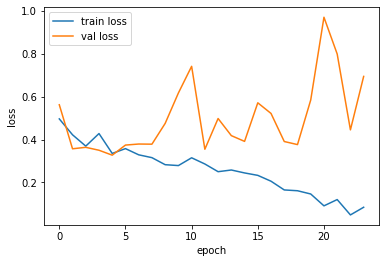

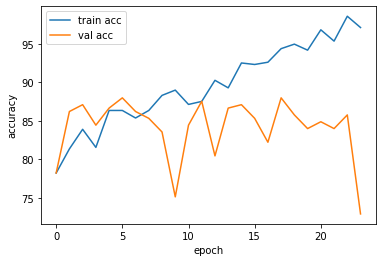

In [9]:
print("Training complete.")
epochs = [x for x in range(24)]
import matplotlib.pyplot as plt
plt.plot(epochs,trnl,label='train loss')
plt.plot(epochs,vall,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()